In [359]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go

In [360]:
import os
import sys

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [361]:
from core.time_series_clustering import KmeansClustering
from core.data_preparation import DataPreparation


In [362]:
from core.curve_fit import fit_polynomial_curve_to_data_and_visualize

Load and Prepare data to input to LSTM model

In [363]:
filepath = "../Data/MRF_clean.csv"
data = pd.read_csv(filepath)
data = data.sort_values('date')
data.head()

,date,close
0,2005-01-03,2542.550049
1,2005-01-04,2550.050049
2,2005-01-05,2577.300049
3,2005-01-06,2512.550049
4,2005-01-07,2498.949951


In [364]:
data.tail()

,date,close
4209,2022-01-21,72697.10156
4210,2022-01-24,71077.35156
4211,2022-01-25,70569.95313
4212,2022-01-27,70712.64844
4213,2022-01-28,71327.70313


In [365]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [366]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['close'], mode='lines', name='closing price'))


In [367]:
window_size = 20
prep = DataPreparation()
scaler = MinMaxScaler(feature_range=(-1, 1))

In [368]:
scaler, x_train, x_test, y_train_gru, y_test_gru = prep.normalize_and_prepare_data(data['close'].values, scaler)

x_train.shape =  (3351, 20, 1)
y_train.shape =  (3351, 1)
x_test.shape =  (823, 20, 1)
y_test.shape =  (823, 1)


In [369]:
num_clusters = 5

In [370]:
kmeans = KmeansClustering(num_clusters)
kmeans.compute_clusters(x_train)

DBA k-means


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


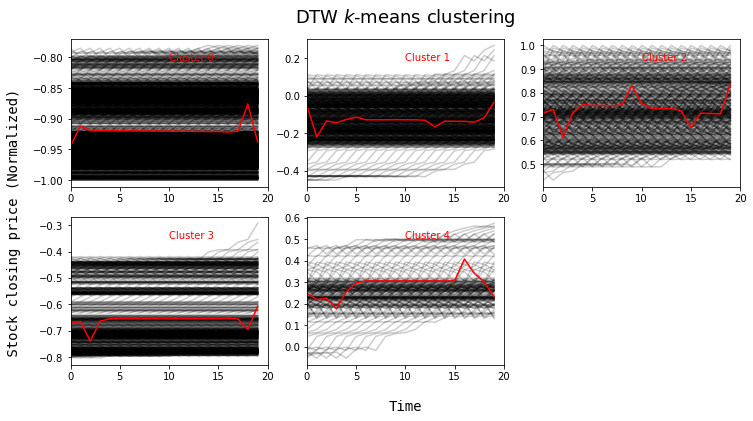

In [371]:
kmeans.visualize_clustering_results()

In [372]:
y_train = y_train_gru.flatten().numpy()

In [373]:
type(y_train)

numpy.ndarray

In [374]:
train_errors = pd.read_csv('MRF_ErrorDistribution_GRU.csv', usecols=[2])
train_errors.head()

,diff
0,685.32007
1,687.78613
2,589.80710
3,527.92554
4,522.91090


In [375]:
clusters = []
for i in range(num_clusters):

    clusters.append(scaler.inverse_transform(kmeans.cluster_centers_[i].flatten().reshape(-1,1)))

In [376]:
kmeans.cluster_centers_[2].flatten()

array([0.71386082, 0.73042381, 0.61190694, 0.71518016, 0.74936105,
       0.74715487, 0.74665733, 0.74543323, 0.74883624, 0.82926145,
       0.75481896, 0.73416054, 0.73379737, 0.73382813, 0.72464114,
       0.65328073, 0.71420514, 0.71271557, 0.71127266, 0.83727514])

In [377]:
train_preds = kmeans.predict(x_train)

In [378]:
model = torch.load('gru_mrf.pt')
model.eval()

GRU(
  (gru): GRU(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [379]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_gru.detach().numpy())

# calculate root mean squared error
test_error = mean_absolute_percentage_error(y_test[:,0], y_pred[:,0])
accuracy_reg = r2_score(y_test[:, 0], y_pred[:, 0])
rmse = math.sqrt(mean_squared_error(y_test[:,0], y_pred[:,0]))
print('Test Score: %.2f MAPE' % (test_error))
print(f'R-squared value is {accuracy_reg}')
print('RMSE: ', rmse)

Test Score: 0.03 MAPE
R-squared value is 0.872105023165994
RMSE:  3666.8273752659807


In [380]:
y_test[:10,0], y_pred[:10,0]

(array([63598.55, 63025.65, 63138.8 , 61603.8 , 61022.2 , 61120.9 ,
        61997.3 , 63979.6 , 63427.5 , 63978.35], dtype=float32),
 array([64900.8  , 64288.12 , 63704.73 , 63358.242, 62738.254, 62101.605,
        61702.094, 61736.156, 62411.418, 62810.14 ], dtype=float32))

#### Predict the cluster for forecast data

In [381]:
#prepare forecasts for clustering

preds = y_test_pred.detach().numpy()
preds = preds[:,0]
loop = len(preds) - window_size + 1 
forecasts = []

for i in range(loop):        
    window = preds[i:i+window_size]
    forecasts.append(window)  

forecasts = np.asarray(forecasts).reshape(-1, window_size, 1)

In [382]:
#prepare test gt for performance comparison

gt = y_test_gru.detach().numpy()
gt = gt[:,0]
loop = len(gt) - window_size + 1 
test_gt = []

for i in range(loop):        
    window = gt[i:i+window_size]
    test_gt.append(window)  

test_gt = np.asarray(test_gt).reshape(-1, window_size, 1)

In [383]:
test_gt.shape, forecasts.shape

((804, 20, 1), (804, 20, 1))

In [384]:
res = kmeans.predict(forecasts)

In [385]:
np.where(res == 6)

(array([], dtype=int64),)

#### Find distances between each cluster centroid and a reference time series

In [386]:
ref_ts = np.zeros(20)

In [387]:
ref_ts

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [388]:
clusters[0].flatten()

array([3745.1278258 , 5006.45425597, 4738.27266712, 4735.15105902,
       4730.47532768, 4721.10105444, 4714.90928357, 4706.98793468,
       4701.19038595, 4696.57059864, 4693.48502076, 4689.72636968,
       4682.24723158, 4676.1210781 , 4671.07583403, 4668.34856252,
       4635.57159608, 4690.9282461 , 6447.4181903 , 3987.3439194 ])

In [389]:
clusters[2].flatten()

array([69510.63488058, 70167.61204469, 65466.5958961 , 69562.96672309,
       70918.76471769, 70831.25578251, 70811.52054439, 70762.96638758,
       70897.947882  , 74088.04418906, 71135.25471234, 70315.83088789,
       70301.42546876, 70302.64560751, 69938.24034672, 67107.70259219,
       69524.29225287, 69465.20789417, 69407.97441144, 74405.91038654])

In [390]:
clusters_wd_dist = []
for i in range(num_clusters):

    wd = kmeans.compute_wasserstein_distance(ref_ts, clusters[i].flatten())

    clusters_wd_dist.append(wd)


In [391]:
clusters_wd_dist

[4644.877125355052,
 36104.03120670783,
 70230.2463705324,
 14919.59130009756,
 52513.9438562388]

In [392]:
f380 = scaler.inverse_transform(forecasts[380].flatten().reshape(-1,1))

In [393]:
kmeans._get_statistical_dist_measures(f380.flatten(), np.zeros(20))

{'Anderson_Darling_dist': 3.708417172625208,
 'CVM_dist': 10.450000000000003,
 'DTS_dist': 18688.353151442563,
 'Kolmogorov_Smirnov_dist': 1.0000000000000002,
 'Kuiper_dist': 1.0000000000000002,
 'Wasserstein distance': 59004.4921875}

In [394]:
len(forecasts)

804

In [395]:
# np.random.seed(4)

## Fix these values of indices to reacreate/edit plots

indices = [580, 731, 671, 287, 482, 764, 444, 646,  99, 591, 177, 546, 258,
         757, 611]

#indices = np.random.choice(range(0, len(forecasts), 1), 15)
#indices

In [396]:
# t = [130, 184, 244, 225, 160, 235, 245, 176, 175, 30, 264, 256, 278, 300, 305, 380, 406, 420, 450, 467]

t = indices
df = kmeans.ecdf_between_cluster_and_data(t, scaler, forecasts, res, clusters_wd_dist)

In [397]:
df

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein distance
0,580,0.984866,2,70230.246371,7.151244,19.95,3420.849239,1.00,1.00,9986.138054
1,731,0.860837,2,70230.246371,7.151244,19.95,1914.411152,1.00,1.00,5075.763835
2,671,0.870262,2,70230.246371,7.151244,19.95,1950.108795,1.00,1.00,5461.386491
3,287,0.556115,2,70230.246371,7.151244,19.95,2433.777446,1.00,1.00,6976.669222
4,482,0.456526,4,52513.943856,5.170010,14.10,2357.309419,1.00,1.00,6655.547848
5,764,0.809109,2,70230.246371,5.829272,16.45,1173.071406,0.90,0.90,3043.921073
6,444,0.523716,2,70230.246371,7.151244,19.95,2832.345017,1.00,1.00,8261.761605
7,646,0.878442,2,70230.246371,6.992891,19.45,2078.702408,0.90,0.90,5782.041570
8,99,0.405413,4,52513.943856,4.944874,13.40,1682.700846,0.95,0.95,4620.917770
9,591,0.961496,2,70230.246371,7.151244,19.95,3092.490008,1.00,1.00,9082.993523


In [398]:
df

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein distance
0,580,0.984866,2,70230.246371,7.151244,19.95,3420.849239,1.00,1.00,9986.138054
1,731,0.860837,2,70230.246371,7.151244,19.95,1914.411152,1.00,1.00,5075.763835
2,671,0.870262,2,70230.246371,7.151244,19.95,1950.108795,1.00,1.00,5461.386491
3,287,0.556115,2,70230.246371,7.151244,19.95,2433.777446,1.00,1.00,6976.669222
4,482,0.456526,4,52513.943856,5.170010,14.10,2357.309419,1.00,1.00,6655.547848
5,764,0.809109,2,70230.246371,5.829272,16.45,1173.071406,0.90,0.90,3043.921073
6,444,0.523716,2,70230.246371,7.151244,19.95,2832.345017,1.00,1.00,8261.761605
7,646,0.878442,2,70230.246371,6.992891,19.45,2078.702408,0.90,0.90,5782.041570
8,99,0.405413,4,52513.943856,4.944874,13.40,1682.700846,0.95,0.95,4620.917770
9,591,0.961496,2,70230.246371,7.151244,19.95,3092.490008,1.00,1.00,9082.993523


In [399]:
df['WD ratio'] = df['Wasserstein distance'] / df['WD origin']

In [400]:
df

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein distance,WD ratio
0,580,0.984866,2,70230.246371,7.151244,19.95,3420.849239,1.00,1.00,9986.138054,0.142191
1,731,0.860837,2,70230.246371,7.151244,19.95,1914.411152,1.00,1.00,5075.763835,0.072273
2,671,0.870262,2,70230.246371,7.151244,19.95,1950.108795,1.00,1.00,5461.386491,0.077764
3,287,0.556115,2,70230.246371,7.151244,19.95,2433.777446,1.00,1.00,6976.669222,0.099340
4,482,0.456526,4,52513.943856,5.170010,14.10,2357.309419,1.00,1.00,6655.547848,0.126739
5,764,0.809109,2,70230.246371,5.829272,16.45,1173.071406,0.90,0.90,3043.921073,0.043342
6,444,0.523716,2,70230.246371,7.151244,19.95,2832.345017,1.00,1.00,8261.761605,0.117638
7,646,0.878442,2,70230.246371,6.992891,19.45,2078.702408,0.90,0.90,5782.041570,0.082330
8,99,0.405413,4,52513.943856,4.944874,13.40,1682.700846,0.95,0.95,4620.917770,0.087994
9,591,0.961496,2,70230.246371,7.151244,19.95,3092.490008,1.00,1.00,9082.993523,0.129332


In [401]:
rmse_errors = []
mape_errors = []
r2score = []
for i in t:

    forecast = scaler.inverse_transform(forecasts[i])
    gt = scaler.inverse_transform(test_gt[i])
    rmse = math.sqrt(mean_squared_error(gt, forecast))
    rmse_errors.append(rmse)

    mape = mean_absolute_percentage_error(gt, forecast)
    mape_errors.append(mape*100)

    r2 = r2_score(gt, forecast)
    r2score.append(r2)

In [402]:
df = df.assign(**{'RMSE': rmse_errors, 'MAPE':mape_errors, 'R2-score': r2score})

In [403]:
df 

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein distance,WD ratio,RMSE,MAPE,R2-score
0,580,0.984866,2,70230.246371,7.151244,19.95,3420.849239,1.00,1.00,9986.138054,0.142191,9577.798077,10.375319,-13.711242
1,731,0.860837,2,70230.246371,7.151244,19.95,1914.411152,1.00,1.00,5075.763835,0.072273,6141.281625,7.086241,-4.289375
2,671,0.870262,2,70230.246371,7.151244,19.95,1950.108795,1.00,1.00,5461.386491,0.077764,5497.306613,6.684221,-34.672880
3,287,0.556115,2,70230.246371,7.151244,19.95,2433.777446,1.00,1.00,6976.669222,0.099340,1224.896322,1.414357,0.461130
4,482,0.456526,4,52513.943856,5.170010,14.10,2357.309419,1.00,1.00,6655.547848,0.126739,1187.702404,1.656822,0.100982
5,764,0.809109,2,70230.246371,5.829272,16.45,1173.071406,0.90,0.90,3043.921073,0.043342,3595.598559,4.388462,-2.348644
6,444,0.523716,2,70230.246371,7.151244,19.95,2832.345017,1.00,1.00,8261.761605,0.117638,1089.291628,1.454855,-0.096614
7,646,0.878442,2,70230.246371,6.992891,19.45,2078.702408,0.90,0.90,5782.041570,0.082330,6355.287562,7.599991,-17.796208
8,99,0.405413,4,52513.943856,4.944874,13.40,1682.700846,0.95,0.95,4620.917770,0.087994,744.150438,1.109311,0.227835
9,591,0.961496,2,70230.246371,7.151244,19.95,3092.490008,1.00,1.00,9082.993523,0.129332,8162.601546,9.113915,-16.498597


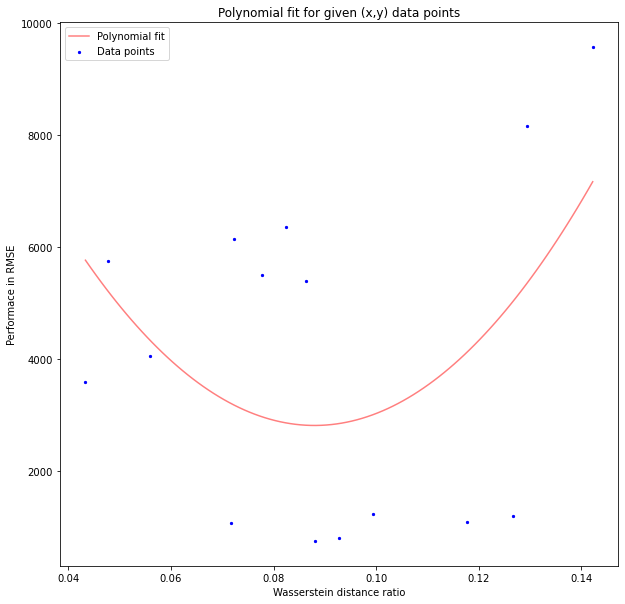

In [404]:
fit_polynomial_curve_to_data_and_visualize(df['WD ratio'].values, rmse_errors, 2, xlabel='Wasserstein distance ratio', ylabel='Performace in RMSE')

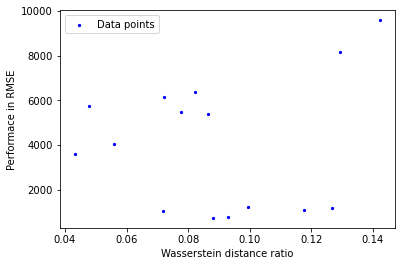

In [405]:
#Plotting
fig1 = plt.figure()
ax1 = fig1.subplots()
ax1.scatter(df['WD ratio'], rmse_errors, s = 5, color = 'b', label = 'Data points')
ax1.set_xlabel('Wasserstein distance ratio')
ax1.set_ylabel('Performace in RMSE')
ax1.legend()
plt.show()

#### Find MSE of each data point using CONFINE method

In [406]:
for i in range(num_clusters):
    print(f"cluster {i}- {len(kmeans.data[kmeans.data_preds == i])}")

cluster 0- 1765
cluster 1- 506
cluster 2- 335
cluster 3- 609
cluster 4- 136


In [407]:
num_neighbors = 136

In [408]:
y_train = y_train_gru.flatten().numpy()

##### Get indices of the training points that have been assigned to respective cluster

In [409]:
cluster0 = (np.where(kmeans.labels_ == 0))
cluster1 = (np.where(kmeans.labels_ == 1))
cluster2 = (np.where(kmeans.labels_ == 2))
cluster3 = (np.where(kmeans.labels_ == 3))
cluster4 = (np.where(kmeans.labels_ == 4))

##### Get the difference between train preds and train gt values 

In [410]:
train_diff_df = pd.read_csv('MRF_ErrorDistribution_GRU.csv', usecols=[2])
train_diff_df.head()

,diff
0,685.32007
1,687.78613
2,589.80710
3,527.92554
4,522.91090


##### Get training points (members) of each cluster 

In [411]:
training_diff = train_diff_df['diff']
training_diff = training_diff.values

In [412]:
type(training_diff)

numpy.ndarray

In [413]:
cluster0_errors = training_diff[cluster0[0]]
cluster1_errors = training_diff[cluster1[0]]
cluster2_errors = training_diff[cluster2[0]]
cluster3_errors = training_diff[cluster3[0]]
cluster4_errors = training_diff[cluster4[0]]


In [414]:
np.random.seed(21)
cluster2_neighbors = np.random.choice(cluster2_errors, num_neighbors, replace=False)
cluster4_neighbors = np.random.choice(cluster4_errors, num_neighbors, replace=False)

In [415]:
cluster2_neighbors

array([1.10541410e+03, 1.00604690e+03, 2.22769530e+03, 2.74695310e+03,
       3.81284380e+03, 2.15917970e+03, 3.81255470e+03, 2.87489840e+03,
       3.94842190e+03, 7.46121100e+02, 5.51003900e+03, 4.30597660e+02,
       4.84914840e+03, 5.87003900e+03, 9.66335940e+02, 2.92460940e+02,
       7.77906250e+02, 3.20775780e+03, 4.15679700e+02, 1.71144530e+03,
       6.01257800e+02, 3.53519530e+02, 1.13079690e+03, 4.93468750e+02,
       3.61104690e+03, 1.36433590e+03, 1.42871880e+03, 5.26757800e+02,
       2.16013280e+03, 1.36308590e+03, 7.05387500e+03, 1.08997660e+03,
       6.88921900e+02, 1.79018750e+03, 4.71915620e+03, 9.81906250e+02,
       8.09585940e+02, 2.56987500e+03, 3.27785160e+03, 5.53035160e+02,
       7.08523440e+02, 1.75132810e+02, 3.10075780e+03, 3.45189060e+03,
       7.70062500e+02, 3.20442190e+03, 1.96997660e+03, 4.87559380e+03,
       8.60750000e+02, 3.31206640e+03, 2.67970310e+03, 5.09486700e+03,
       4.80196100e+03, 5.80964840e+02, 4.96532030e+03, 2.37171880e+02,
      

In [416]:
squared_error_2 = [n ** 2 for n in cluster2_neighbors]
squared_error_2 = np.array(squared_error_2)

In [417]:
squared_error_4 = [n ** 2 for n in cluster4_neighbors]
squared_error_4 = np.array(squared_error_4)

In [418]:
scaler = MinMaxScaler(feature_range=(0, 1))
se_norm_2 = scaler.fit_transform(squared_error_2.reshape(-1, 1))

In [419]:
scaler = MinMaxScaler(feature_range=(0, 1))
se_norm_4 = scaler.fit_transform(squared_error_4.reshape(-1, 1))

In [420]:
se_norm_2 = np.around(se_norm_2, 4)

In [421]:
se_norm_4 = np.around(se_norm_4, 4)

In [422]:
mse_2 = np.mean(se_norm_2)

In [423]:
mse_2 = np.round(mse_2, 4)
mse_2

0.1351

In [424]:
mse_4 = np.mean(se_norm_4)

In [425]:
mse_4 = np.round(mse_4, 4)
mse_4

0.1101

In [426]:
confine_mse = []

In [427]:
for i in df['Assigned cluster']:
    print(i)

2
2
2
2
4
2
2
2
4
2
4
2
2
2
2


In [428]:
for i in df['Assigned cluster']:

    if i==2:
        confine_mse.append(mse_2) 
    elif i==4:
        confine_mse.append(mse_4)    


# confine_mse = [0.3188, 0.2606, 0.3188, 0.3188, 0.3188, 0.3188, 0.3188, 0.2606, 0.3188, 0.3188, 0.3188, 0.3188,
#                 0.3188, 0.3188, 0.3188, 0.3188, 0.3188, 0.3188, 0.3188, 0.3188]

In [429]:
len(confine_mse)

15

In [430]:
df['mse'] = confine_mse

In [431]:
df

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein distance,WD ratio,RMSE,MAPE,R2-score,mse
0,580,0.984866,2,70230.246371,7.151244,19.95,3420.849239,1.00,1.00,9986.138054,0.142191,9577.798077,10.375319,-13.711242,0.1351
1,731,0.860837,2,70230.246371,7.151244,19.95,1914.411152,1.00,1.00,5075.763835,0.072273,6141.281625,7.086241,-4.289375,0.1351
2,671,0.870262,2,70230.246371,7.151244,19.95,1950.108795,1.00,1.00,5461.386491,0.077764,5497.306613,6.684221,-34.672880,0.1351
3,287,0.556115,2,70230.246371,7.151244,19.95,2433.777446,1.00,1.00,6976.669222,0.099340,1224.896322,1.414357,0.461130,0.1351
4,482,0.456526,4,52513.943856,5.170010,14.10,2357.309419,1.00,1.00,6655.547848,0.126739,1187.702404,1.656822,0.100982,0.1101
5,764,0.809109,2,70230.246371,5.829272,16.45,1173.071406,0.90,0.90,3043.921073,0.043342,3595.598559,4.388462,-2.348644,0.1351
6,444,0.523716,2,70230.246371,7.151244,19.95,2832.345017,1.00,1.00,8261.761605,0.117638,1089.291628,1.454855,-0.096614,0.1351
7,646,0.878442,2,70230.246371,6.992891,19.45,2078.702408,0.90,0.90,5782.041570,0.082330,6355.287562,7.599991,-17.796208,0.1351
8,99,0.405413,4,52513.943856,4.944874,13.40,1682.700846,0.95,0.95,4620.917770,0.087994,744.150438,1.109311,0.227835,0.1101
9,591,0.961496,2,70230.246371,7.151244,19.95,3092.490008,1.00,1.00,9082.993523,0.129332,8162.601546,9.113915,-16.498597,0.1351


In [432]:
df['staDRE'] = (2 - df['mse'] - df['WD ratio'] ) / 2

In [433]:
df_RE = df[['Test point', 'Assigned cluster', 'RMSE', 'MAPE', 'R2-score', 'WD origin', 'Wasserstein distance', 'WD ratio', 'mse', 'staDRE']]

In [434]:
df_RE

,Test point,Assigned cluster,RMSE,MAPE,R2-score,WD origin,Wasserstein distance,WD ratio,mse,staDRE
0,580,2,9577.798077,10.375319,-13.711242,70230.246371,9986.138054,0.142191,0.1351,0.861354
1,731,2,6141.281625,7.086241,-4.289375,70230.246371,5075.763835,0.072273,0.1351,0.896313
2,671,2,5497.306613,6.684221,-34.672880,70230.246371,5461.386491,0.077764,0.1351,0.893568
3,287,2,1224.896322,1.414357,0.461130,70230.246371,6976.669222,0.099340,0.1351,0.882780
4,482,4,1187.702404,1.656822,0.100982,52513.943856,6655.547848,0.126739,0.1101,0.881581
5,764,2,3595.598559,4.388462,-2.348644,70230.246371,3043.921073,0.043342,0.1351,0.910779
6,444,2,1089.291628,1.454855,-0.096614,70230.246371,8261.761605,0.117638,0.1351,0.873631
7,646,2,6355.287562,7.599991,-17.796208,70230.246371,5782.041570,0.082330,0.1351,0.891285
8,99,4,744.150438,1.109311,0.227835,52513.943856,4620.917770,0.087994,0.1101,0.900953
9,591,2,8162.601546,9.113915,-16.498597,70230.246371,9082.993523,0.129332,0.1351,0.867784


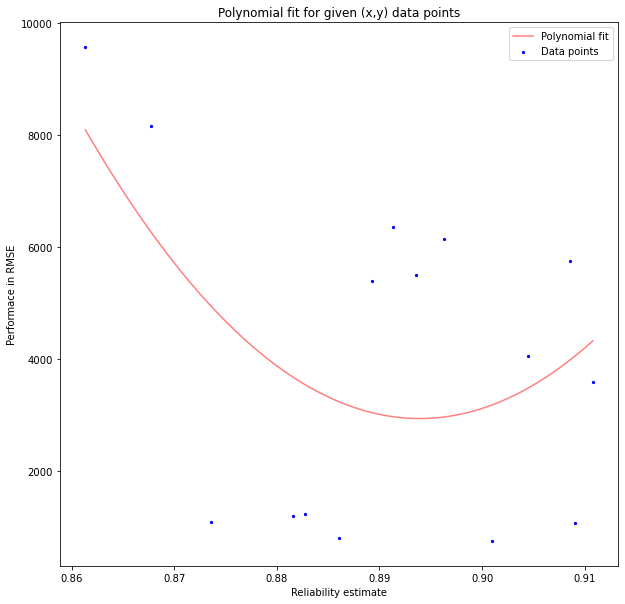

In [435]:
fit_polynomial_curve_to_data_and_visualize(df['staDRE'].values, df['RMSE'].values, 2, xlabel='Reliability estimate', ylabel='Performace in RMSE')

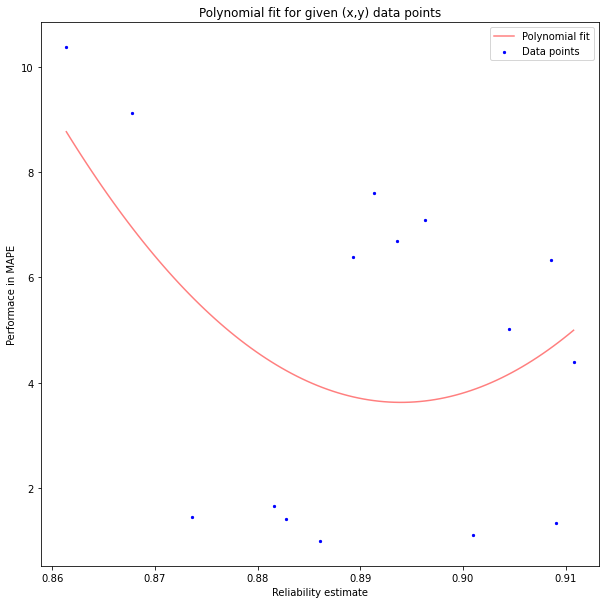

In [436]:
fit_polynomial_curve_to_data_and_visualize(df['staDRE'].values, df['MAPE'].values, 2, xlabel='Reliability estimate', ylabel='Performace in MAPE')

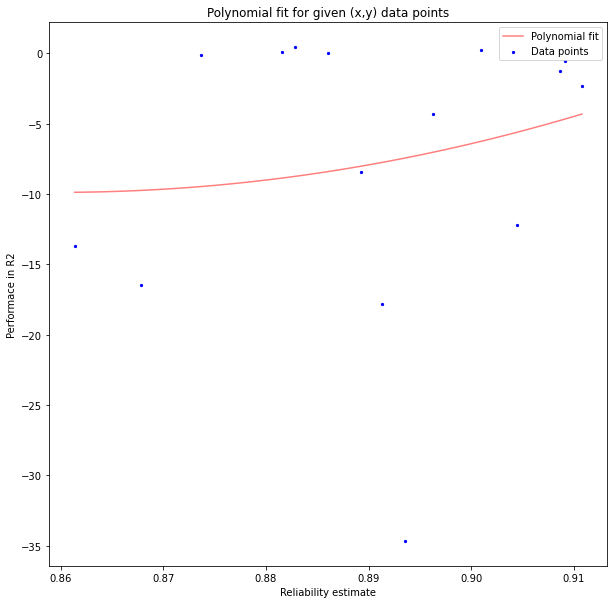

In [437]:
fit_polynomial_curve_to_data_and_visualize(df['staDRE'].values, df['R2-score'].values, 2, xlabel='Reliability estimate', ylabel='Performace in R2')

In [438]:
#df_RE.to_csv('MRF_stadre.csv', index=False)

In [439]:
scaler = MinMaxScaler()

In [440]:
x = np.array(df_RE['staDRE'].values)
y = np.array(df_RE['RMSE'].values)

z = np.polyfit(x, y, 2)

fit = np.poly1d(z)

x_min = x.min()
x_max = x.max()

xp = np.linspace(x_min, x_max, 100)
yp = fit(xp)

In [441]:
xmape = np.array(df_RE['staDRE'].values)
ymape = np.array(df_RE['MAPE'].values)

zmape = np.polyfit(xmape, ymape, 2)

fitmape = np.poly1d(zmape)

xmape_min = xmape.min()
xmape_max = xmape.max()

xpmape = np.linspace(xmape_min, xmape_max, 100)
ypmape = fitmape(xpmape)

In [442]:
xr2 = np.array(df_RE['staDRE'].values)
yr2 = np.array(df_RE['R2-score'].values)

zr2 = np.polyfit(xr2, yr2, 2)

fitr2 = np.poly1d(zr2)

xr2_min = xr2.min()
xr2_max = xr2.max()

xpr2 = np.linspace(xr2_min, xr2_max, 100)
ypr2 = fitr2(xpr2)

In [443]:
fitr2

poly1d([ 2141.0881145 , -3681.75483591,  1572.88171811])

In [444]:
yr2

array([-13.71124151,  -4.28937543, -34.67288012,   0.46113007,
         0.10098205,  -2.34864422,  -0.09661431, -17.79620789,
         0.22783495, -16.49859666,  -0.5324101 ,  -1.24053598,
         0.03884927, -12.17038772,  -8.40944941])

In [445]:
fit

poly1d([ 4868822.37780689, -8704545.21212672,  3893460.11298314])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


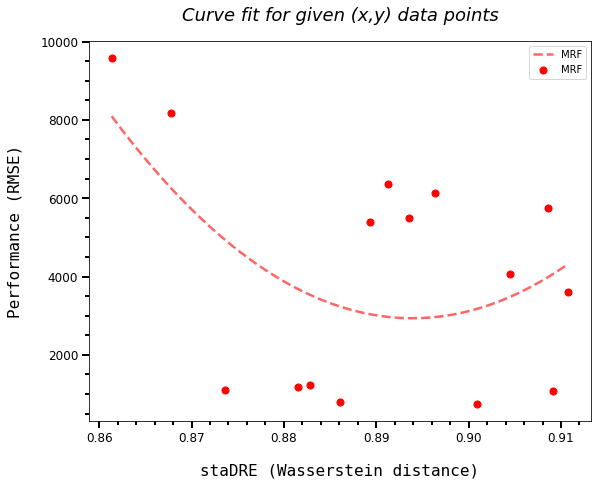

In [446]:
#Plotting RMSE-staDRE
fig1 = plt.figure(figsize=(9,7))
ax1 = fig1.subplots()
ax1.plot(xp, yp, 'r', linestyle='dashed', linewidth=2.5, alpha = 0.6, label = 'MRF')
ax1.scatter(x, y, 50, 'r', "o", label = 'MRF')
ax1.set_xlabel('staDRE (Wasserstein distance)', fontsize=16, family='monospace')
plt.xticks(fontsize=12)
ax1.tick_params(which='both', width=2, length=7)
ax1.tick_params(which='minor', length=4)
ax1.xaxis.labelpad = 18
ax1.set_ylabel('Performance (RMSE)', fontsize=16, family='monospace')
plt.yticks(fontsize=12)
ax1.yaxis.labelpad = 18
ax1.set_title('Curve fit for given (x,y) data points', fontsize=18, style='italic', pad=20)
plt.minorticks_on()
ax1.legend(loc='best')

plt.savefig('RMSE_vs._staDRE.eps', dpi=500)
plt.savefig('RMSE_vs._staDRE.jpg', dpi=500)
plt.savefig('RMSE_vs._staDRE.svg', dpi=500)
plt.show()



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


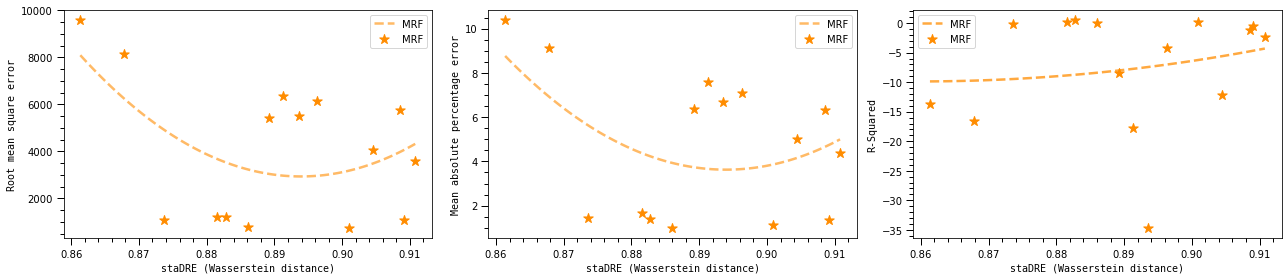

In [447]:
from matplotlib.ticker import MultipleLocator
#Plotting RMSE-staDRE
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
ax1.plot(xp, yp, 'darkorange', linestyle='dashed', linewidth=2.5, alpha = 0.6, label = 'MRF')
ax1.scatter(x, y, 100, 'darkorange', "*", label = 'MRF')
ax1.set_xlabel('staDRE (Wasserstein distance)', fontsize=10, family='monospace')
ax1.minorticks_on()
#ax1.yaxis.set_minor_locator(MultipleLocator(4))
ax1.tick_params(which='both', width=1, length=7)
ax1.tick_params(which='minor', length=4)
ax1.set_ylabel('Root mean square error', fontsize=10, family='monospace')
ax1.legend(loc='best')

ax2.plot(xpmape, ypmape, 'darkorange', linestyle='dashed', linewidth=2.5, alpha = 0.6, label = 'MRF')
ax2.scatter(xmape, ymape, 100, 'darkorange', "*", label = 'MRF')
ax2.set_xlabel('staDRE (Wasserstein distance)', fontsize=10, family='monospace')
ax2.minorticks_on()
ax2.tick_params(which='both', width=1, length=7)
ax2.tick_params(which='minor', length=4)
ax2.set_ylabel('Mean absolute percentage error', fontsize=10, family='monospace')
ax2.legend(loc='best')

ax3.plot(xpr2, ypr2, 'darkorange', linestyle='dashed', linewidth=2.5, alpha = 0.75, label = 'MRF')
ax3.scatter(xr2, yr2, 100, 'darkorange', "*", label = 'MRF')
ax3.set_xlabel('staDRE (Wasserstein distance)', fontsize=10, family='monospace')
ax3.minorticks_on()
ax3.tick_params(which='both', width=1, length=7)
ax3.tick_params(which='minor', length=4)
ax3.set_ylabel('R-Squared', fontsize=10, family='monospace')
ax3.legend(loc='best')


plt.savefig('MRF_staDRE_GRU_1.eps', dpi=500, bbox_inches='tight')
plt.savefig('MRF_staDRE_GRU_1.jpg', dpi=500, bbox_inches='tight')
plt.tight_layout()
plt.show()



##### End of code for Reliability estimate

In [448]:
# plot forecasts[225]
assigned_cluster, plt1 = kmeans.visualize_cluster_assignement_forecast(225, forecasts, res)
print("assigned cluster: ", assigned_cluster)
plt1.plot(kmeans.cluster_centers_[0].ravel(), "g-")
plt1.plot(kmeans.cluster_centers_[1].ravel(), "b-")
plt1.plot(kmeans.cluster_centers_[3].ravel(), "m-")
plt1.plot(kmeans.cluster_centers_[4].ravel(), "olive")
plt1.plot(kmeans.cluster_centers_[5].ravel(), "c")
plt1.plot(kmeans.cluster_centers_[6].ravel(), "purple")
plt1.show()

AttributeError: 'KmeansClustering' object has no attribute 'visualize_cluster_assignement_forecast'

In [ ]:
assigned_cluster, plt1 = kmeans.visualize_cluster_assignement_forecast(30, forecasts, res)
print("assigned cluster: ", assigned_cluster)
plt1.plot(kmeans.cluster_centers_[0].ravel(), "g-")
plt1.plot(kmeans.cluster_centers_[1].ravel(), "b-")
plt1.plot(kmeans.cluster_centers_[2].ravel(), "m-")
plt1.plot(kmeans.cluster_centers_[4].ravel(), "olive")
plt1.plot(kmeans.cluster_centers_[5].ravel(), "c")
plt1.plot(kmeans.cluster_centers_[6].ravel(), "purple")
plt1.show()

In [ ]:
assigned_cluster, plt1 = kmeans.visualize_cluster_assignement_forecast(380, forecasts, res)
print("assigned cluster: ", assigned_cluster)
plt1.plot(kmeans.cluster_centers_[0].ravel(), "g-")
plt1.plot(kmeans.cluster_centers_[1].ravel(), "b-")
plt1.plot(kmeans.cluster_centers_[3].ravel(), "m-")
plt1.plot(kmeans.cluster_centers_[4].ravel(), "olive")
plt1.plot(kmeans.cluster_centers_[5].ravel(), "c")
plt1.plot(kmeans.cluster_centers_[6].ravel(), "purple")
plt1.show()

In [ ]:
assigned_cluster, plt1 = kmeans.visualize_cluster_assignement_forecast(380, forecasts, res)
print("assigned cluster: ", assigned_cluster)
plt1.plot(kmeans.cluster_centers_[0].ravel(), "g-")
plt1.plot(kmeans.cluster_centers_[1].ravel(), "b-")
plt1.plot(kmeans.cluster_centers_[3].ravel(), "m-")
plt1.plot(kmeans.cluster_centers_[4].ravel(), "olive")
plt1.plot(kmeans.cluster_centers_[5].ravel(), "c")
plt1.plot(kmeans.cluster_centers_[6].ravel(), "purple")
plt1.show()